In [35]:
import csv
import collections
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt 
import copy

In [51]:
num_buses = 30
num_gen = 6
generators = np.array([0,1,12,21,22,26]) # indexing so -1
cost_vec = np.array([100, 150, 240, 350, 500, 300], dtype=float) # cost of each generator
carbon_emission_rate_vec = np.array([2159, 2002, 1611, 890, 577, 113], dtype=float) # carbon emission of each generator co2/mhw
graph = collections.defaultdict(list) # from: (to, line)
graph_reverse = collections.defaultdict(list) # to: (from, line)
line_to_nodes = []
with open('30bus_topology.csv', 'r') as csvfile:
    next(csvfile)
    for line in csvfile:
        l = list(map(lambda x: int(x)-1, line.split(','))) # turn "1,2" to [1,2]
        graph[l[0]].append((l[1], len(line_to_nodes)))
        graph_reverse[l[1]].append((l[0], len(line_to_nodes)))
        line_to_nodes.append(l)
num_lines = len(line_to_nodes)
load = np.random.uniform(0.2, 1.8, (num_buses, 1)) # load vector i.e. power demand at each bus/node
print(graph)


defaultdict(<class 'list'>, {0: [(1, 0), (2, 1)], 1: [(3, 2), (4, 4), (5, 5)], 2: [(3, 3)], 3: [(5, 6), (11, 14)], 4: [(6, 7)], 5: [(6, 8), (7, 9), (8, 10), (9, 11), (27, 40)], 8: [(10, 12), (9, 13)], 11: [(12, 15), (13, 16), (14, 17), (15, 18)], 13: [(14, 19)], 15: [(16, 20)], 14: [(17, 21), (22, 29)], 17: [(18, 22)], 18: [(19, 23)], 9: [(19, 24), (16, 25), (20, 26), (21, 27)], 20: [(21, 28)], 21: [(23, 30)], 22: [(23, 31)], 23: [(24, 32)], 24: [(25, 33), (26, 34)], 27: [(26, 35)], 26: [(28, 36), (29, 37)], 28: [(29, 38)], 7: [(27, 39)]})


In [52]:
#DCOPF
# minimize cost_vec.T @ power_generation i.e. equation 5(a)
line_flow_limit = np.full((num_lines, 1), 4.0) # largest line flow rate
neg_line_flow_limit = np.full((num_lines, 1), -4.0) # smallest line flow
power_generation_limit = np.array([[10.0, 15.0, 15.0, 15.0, 15.0, 15.0]]).T # upper limit of power generation for each generator
neg_power_generation_limit = np.full((num_gen, 1), -0.0) # lower limit

In [53]:
def get_avg_carbon(load):
    graph_copy = copy.deepcopy(graph)
    graph_reverse_copy = copy.deepcopy(graph_reverse)
    power_generation = cp.Variable(shape=(num_gen, 1)) # shape [num_gen, 1]
    line_flow = cp.Variable(shape=(num_lines, 1)) # shape [num_line, 1]
    # condition 5(b)
    b = np.zeros((num_buses, num_gen), dtype=float) # a matrix to convert power_generation from [x1, x2, x3, x4, x5, x6] to [x1, x2, 0,0,0,0,0,0,0,0,0,x3, ...] of size 30*1
    # b @ power_generation = new_power_generation
    for i, v in enumerate(generators):
        b[v][i] = 1.0
    a = np.zeros((num_buses, num_lines), dtype=float) # this matrix uses ie. 1.0/-1.0 to represent inflow/outflow. 
    # for example, line 0 is [1,2], which means power flows from bus 1 to bus 2 at line flow rate x0 at line 0. 
    # We would -x0 at index 0 of new line flow and +x0 at index 1 of new line flow. 
    # So the new line flow of shape [num_bus, 1] means at each bus/node, what is the power flow (inflow-outflow at the node).
    for i, v in enumerate(line_to_nodes):
        a[v[0]][i] = 1.0
        a[v[1]][i] = -1.0

    prob = cp.Problem(cp.Minimize(cp.sum(cost_vec @ power_generation)), # eq 5(a)
                    [b @ power_generation - load == a @ line_flow, # eqation 5(b) meaning: at each node/bus the power generated at this bus(some bus are generator) + the power inflow(can be negative) == the power demand at the bus
                    line_flow <= line_flow_limit, # eq 5(c)
                    line_flow >= neg_line_flow_limit, # eq 5(c)
                    power_generation <= power_generation_limit, # eq 5(d)
                    power_generation >= neg_power_generation_limit]) # eq 5(d)
    prob.solve(solver=cp.CVXOPT)
    #print(line_flow.value)
    #print(prob.status)
    for i, f in enumerate(line_flow.value):
        if f < 0.0:
            from_node, to_node = line_to_nodes[i]
            graph_copy[from_node].remove((to_node, i))
            graph_copy[to_node].append((from_node, i))
            graph_reverse_copy[to_node].remove((from_node, i))
            graph_reverse_copy[from_node].append((to_node, i))
            line_flow.value[i] = -f
    line_to_gen = collections.defaultdict(set)
    node_to_gen = collections.defaultdict(set)
    def dfs(g, n, visited):
        if n in visited: return
        visited.add(n)
        node_to_gen[n].add(g)
        for nei, line in graph_copy[n]:
            line_to_gen[line].add(g)
            dfs(g, nei, visited)

    for i, g in enumerate(generators):
        visited = set()
        if power_generation.value[i] >= 0.0001:
            dfs(g, g, visited)
    line_prop_mat=np.zeros((num_gen, num_lines), dtype=float)
    bus_prop_mat=np.zeros((num_gen, num_buses), dtype=float)
    # initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
    for k, v in node_to_gen.items():
        if len(v) == 1:
            idx = list(generators).index(list(v)[0])
            bus_prop_mat[idx][k] = 1.0
    for k, v in line_to_gen.items():
        if len(v) == 1:
            idx = list(generators).index(list(v)[0])
            line_prop_mat[idx][k] = 1.0
    # visit nodes in topological order
    # step 1: calculate bus_prop based on in flowing lines_prop
    # step 2: calculate line_prop of out flowing lines
    in_degree = collections.defaultdict(int)
    for i, v in graph_reverse_copy.items():
        in_degree[i] = len(v)
    q = [] # list of nodes with no inflow
    topo_order = []
    for g in generators:
        if in_degree[g] == 0:
            q.append(g)
    while q:
        cur = q.pop(0)
        if len(node_to_gen[cur]) > 1:
            out_total = load[cur][0]
            for nei, out_line in graph_copy[cur]:
                out_total += line_flow.value[out_line]
            for g in node_to_gen[cur]:
                idx = list(generators).index(g)
                if cur == g:
                    bus_prop_mat[idx][cur] = power_generation.value[idx]/out_total
                else:
                    for nei, in_line in graph_reverse_copy[cur]:
                        bus_prop_mat[idx][cur] += line_flow.value[in_line]*line_prop_mat[idx][in_line]/out_total
            for g in node_to_gen[cur]:
                idx = list(generators).index(g)
                for nei, out_line in graph_copy[cur]:
                    line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]

        topo_order.append(cur)
        for nei, line in graph_copy[cur]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0:
                q.append(nei)
    avg_carbon_emission_rate_node = carbon_emission_rate_vec @ bus_prop_mat
    return avg_carbon_emission_rate_node

In [55]:
percent = [0.2, 0.4, 0.6, 0.8, 1.0]
res = []
for p in percent:
    load = p*load
    res.append(get_avg_carbon(load))
    load = load/p
res = np.array(res) # shape: [len(percent), num_buses]

optimal
optimal
optimal


C:\Users\syq41\AppData\Local\Temp\ipykernel_33668\31672408.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bus_prop_mat[idx][cur] += line_flow.value[in_line]*line_prop_mat[idx][in_line]/out_total
C:\Users\syq41\AppData\Local\Temp\ipykernel_33668\31672408.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bus_prop_mat[idx][cur] = power_generation.value[idx]/out_total


optimal
optimal


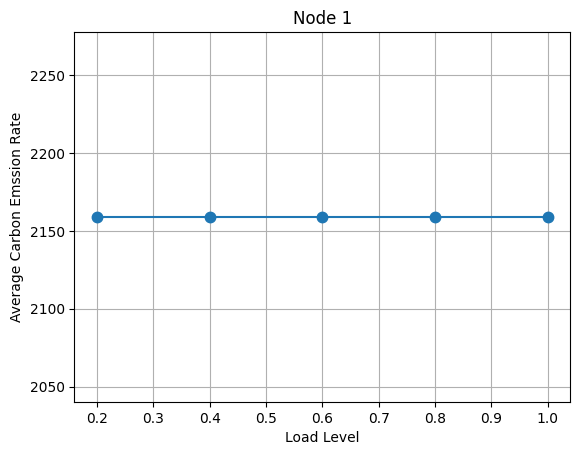

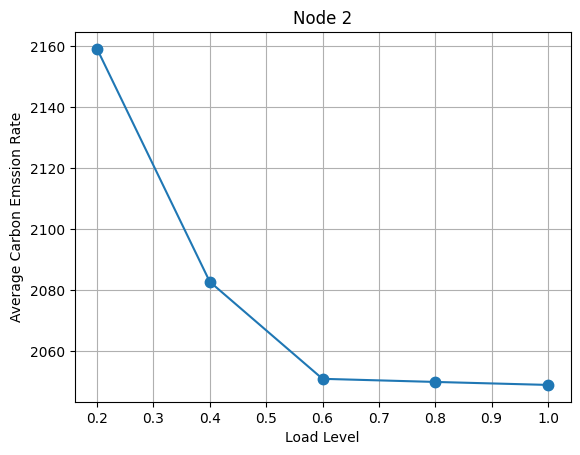

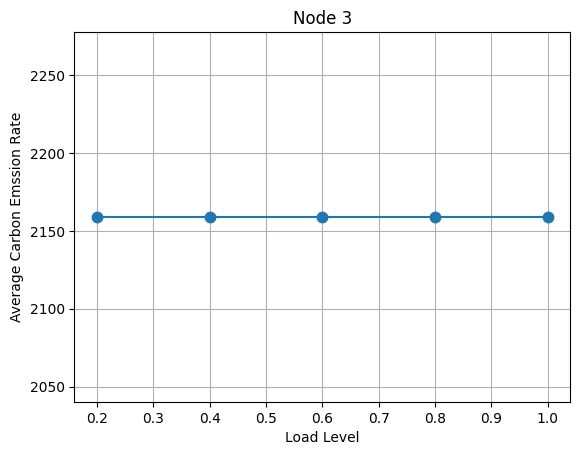

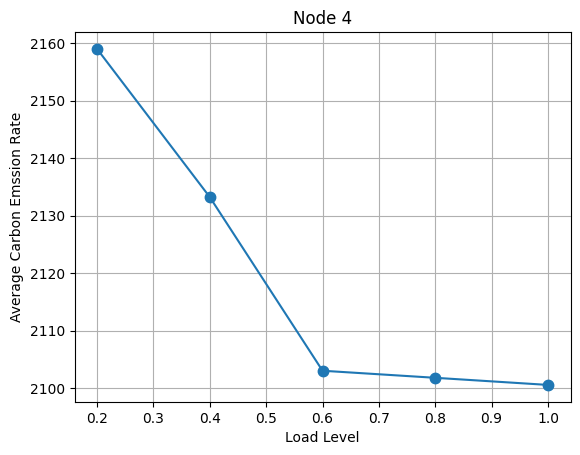

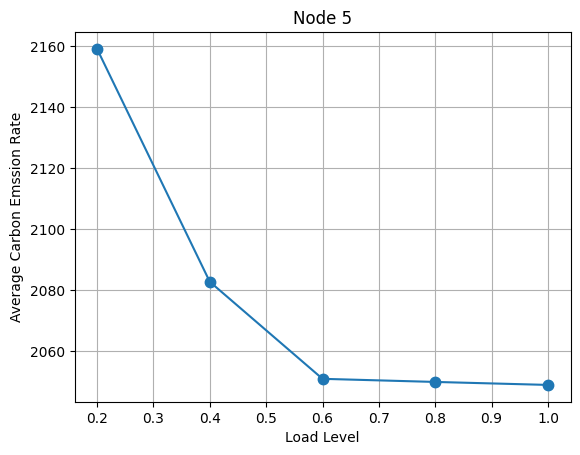

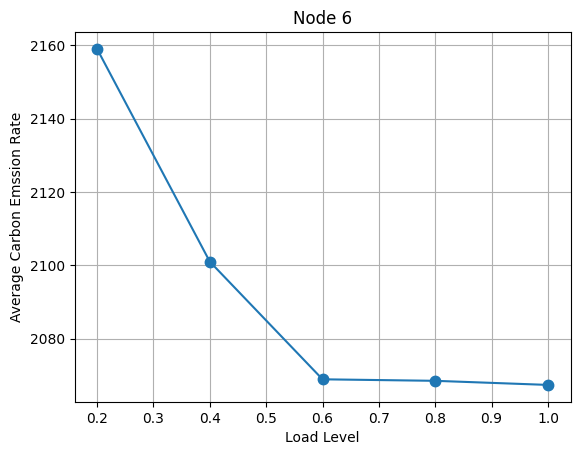

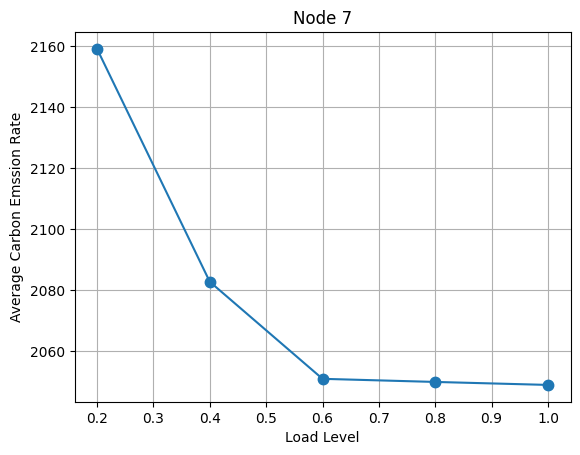

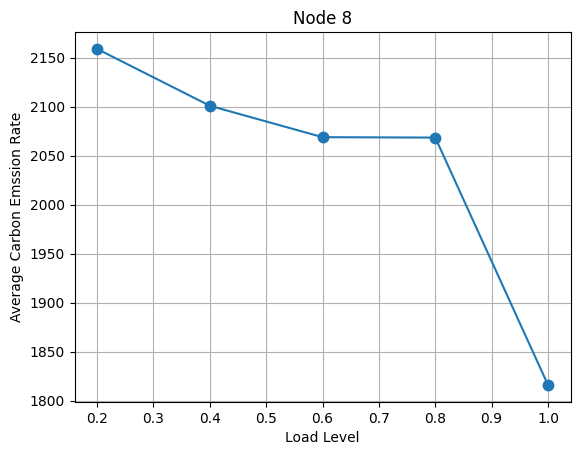

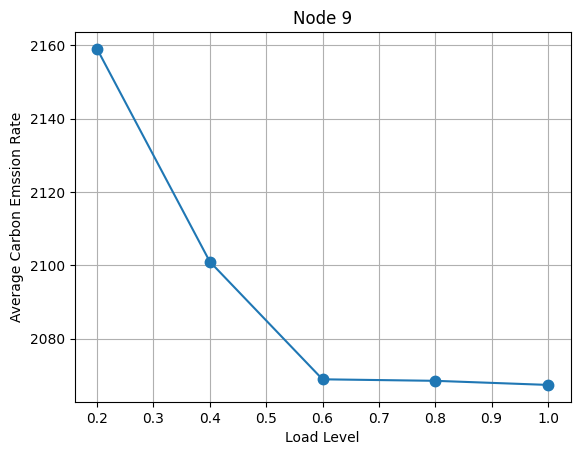

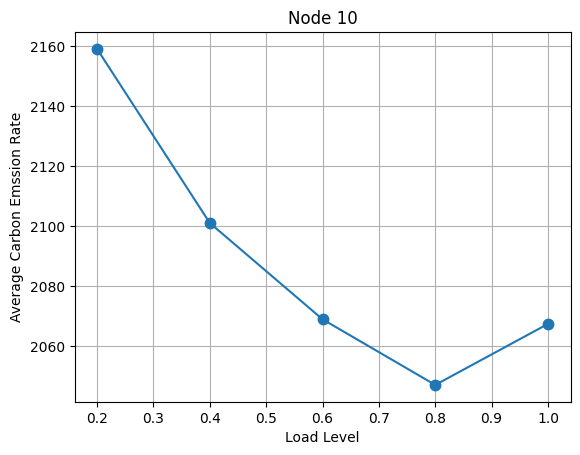

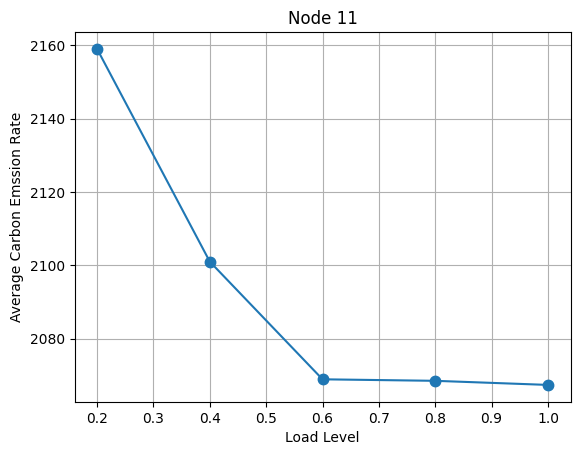

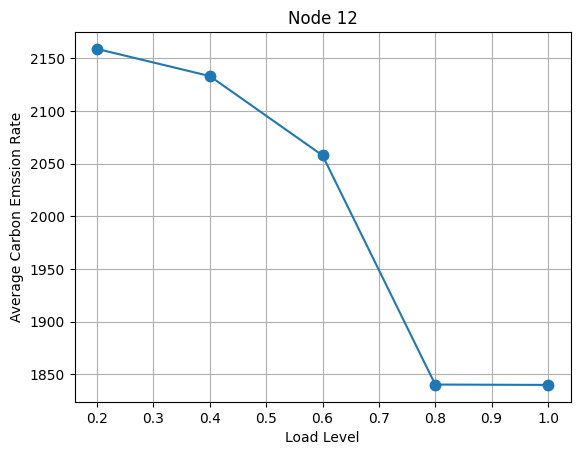

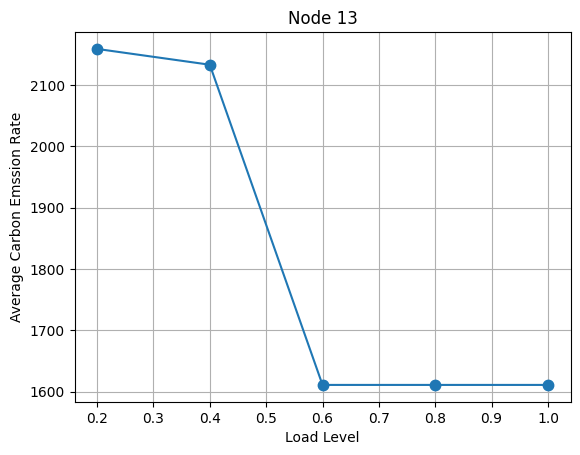

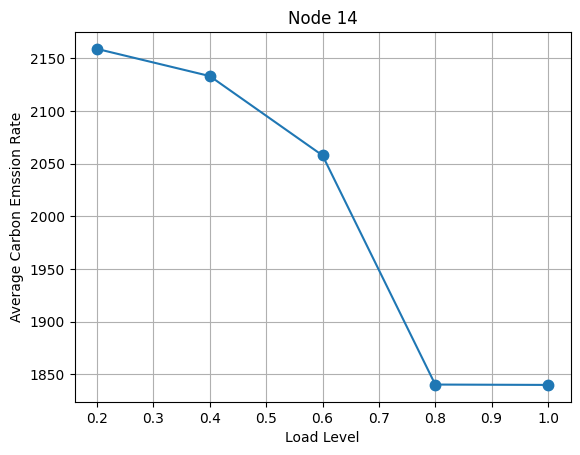

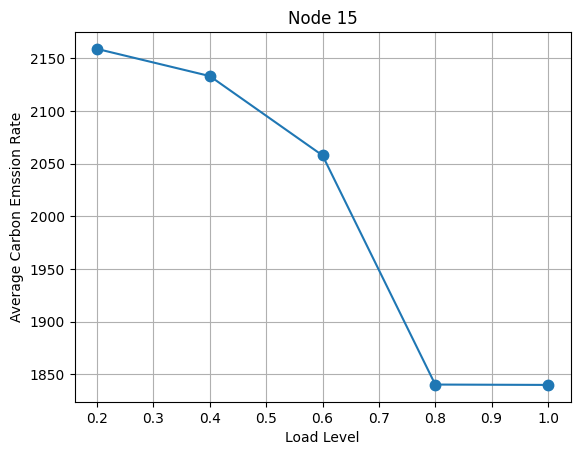

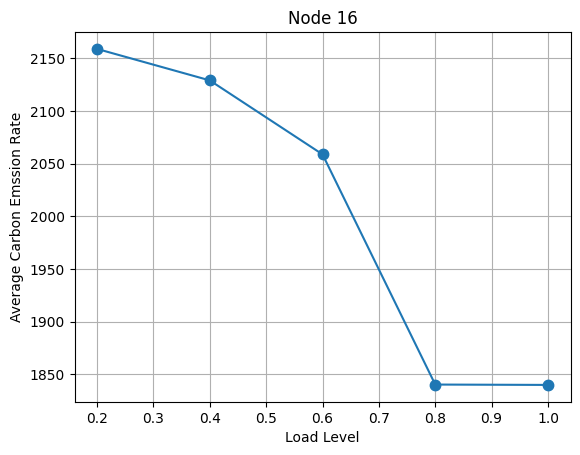

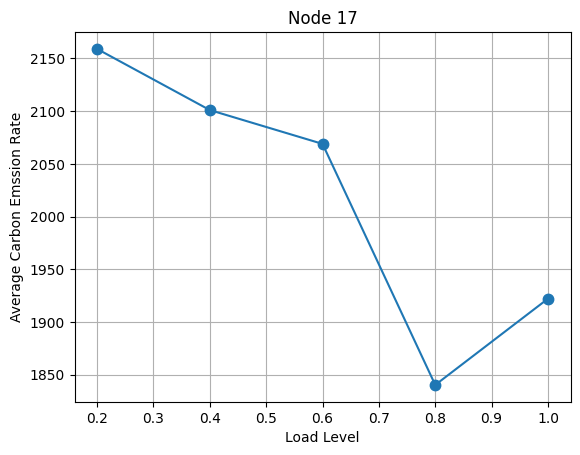

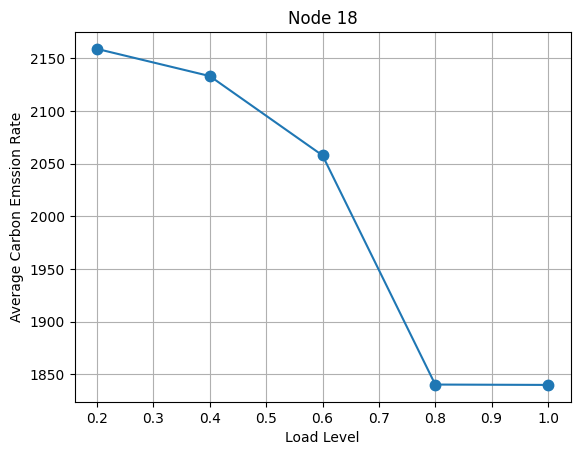

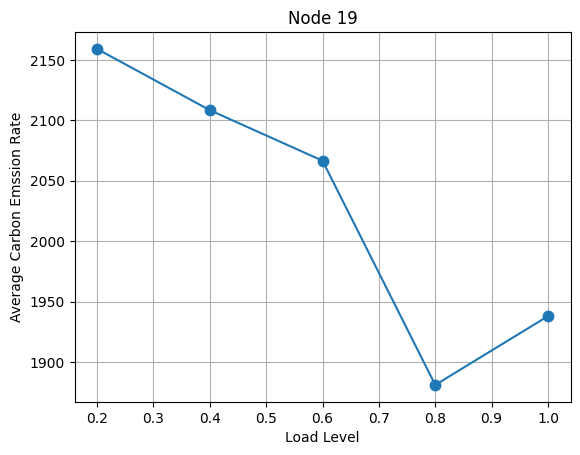

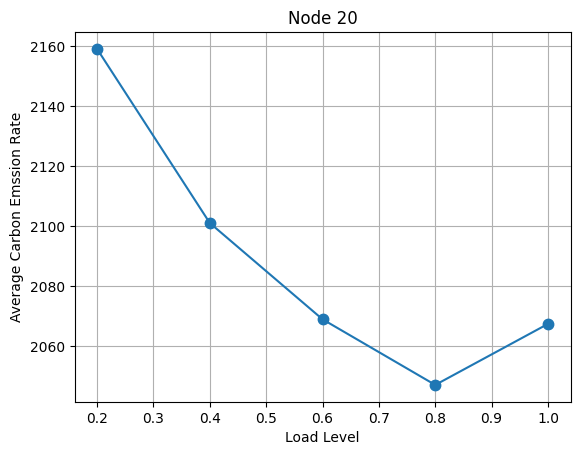

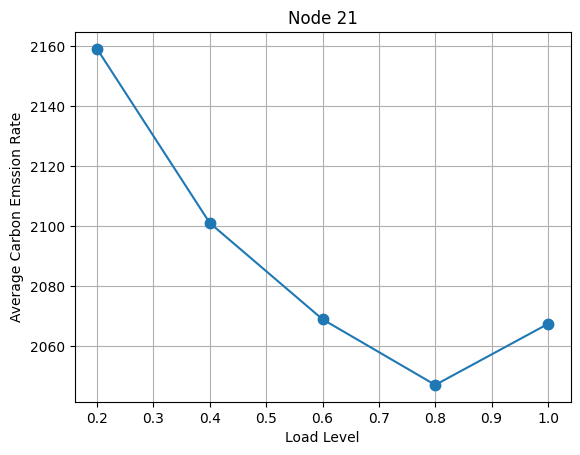

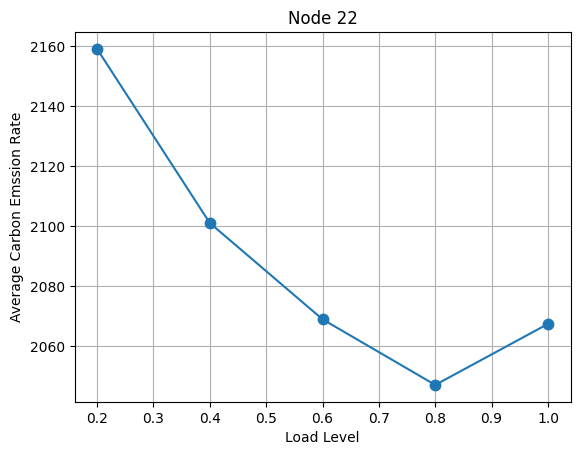

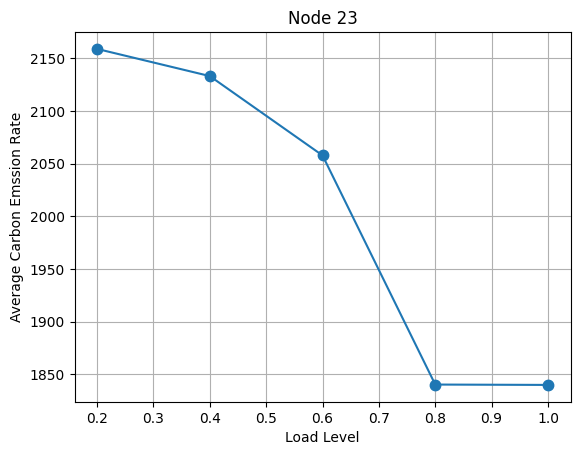

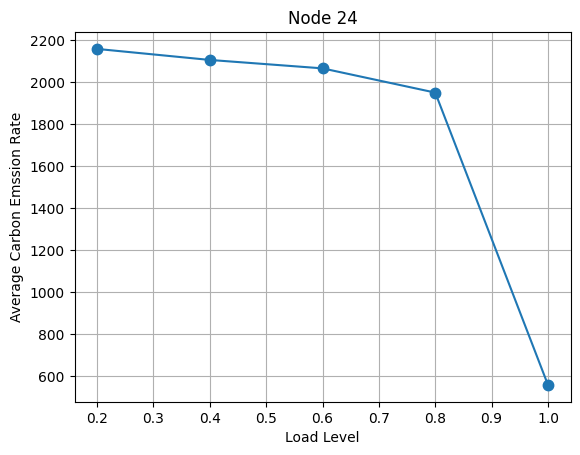

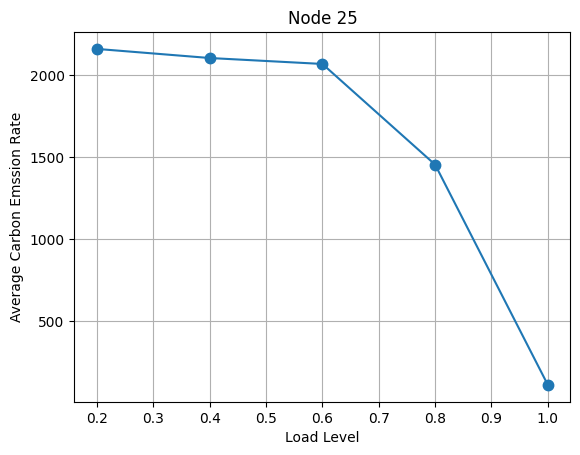

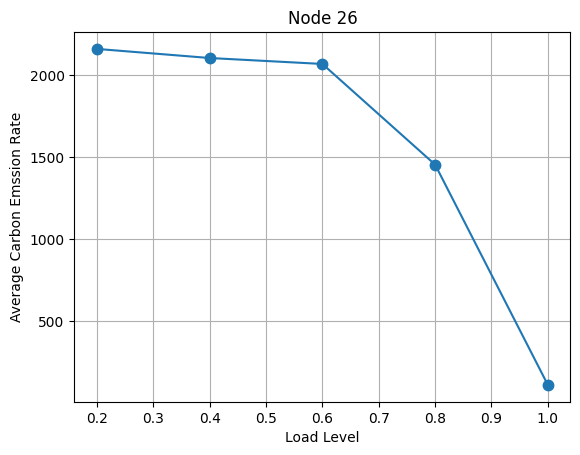

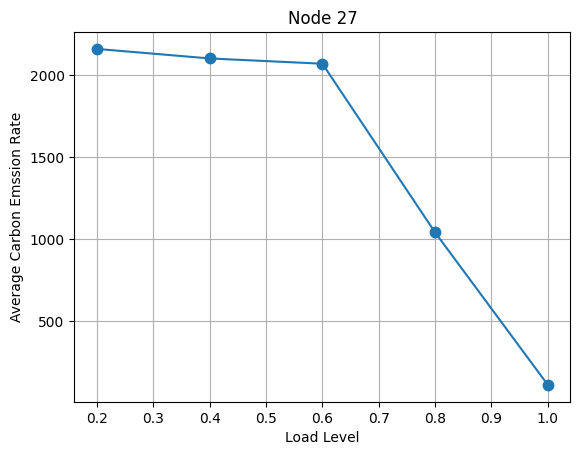

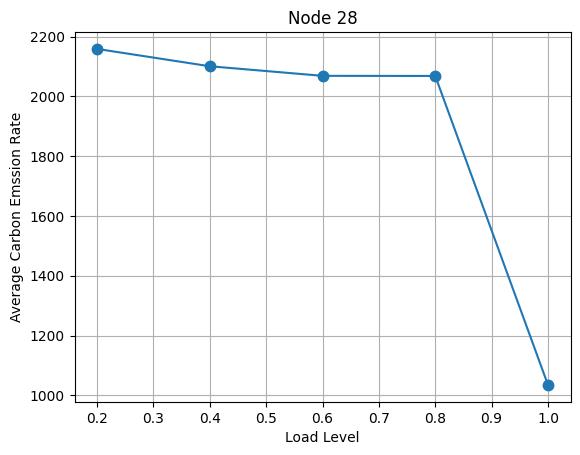

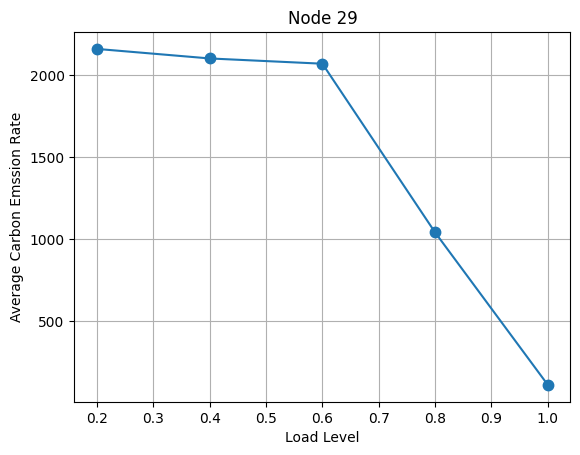

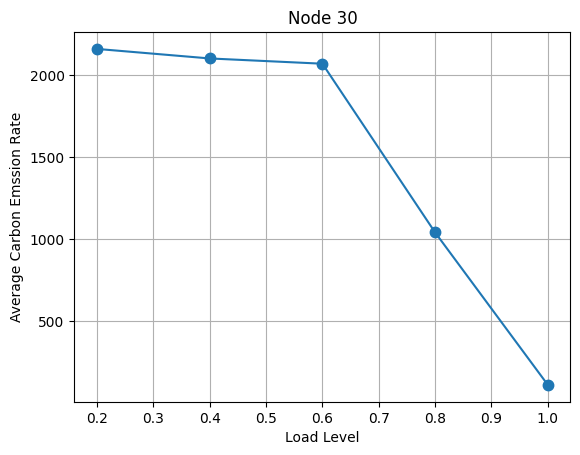

In [56]:
for n in range(num_buses):
    plt.title("Node " + str(n+1))
    plt.xlabel("Load Level")
    plt.ylabel("Average Carbon Emssion Rate")
    plt.plot([0.2,0.4,0.6,0.8,1.0], res[:, n], marker=".", markersize=15)
    plt.grid()
    plt.show()


Text(0.5, 0, 'Load Level')

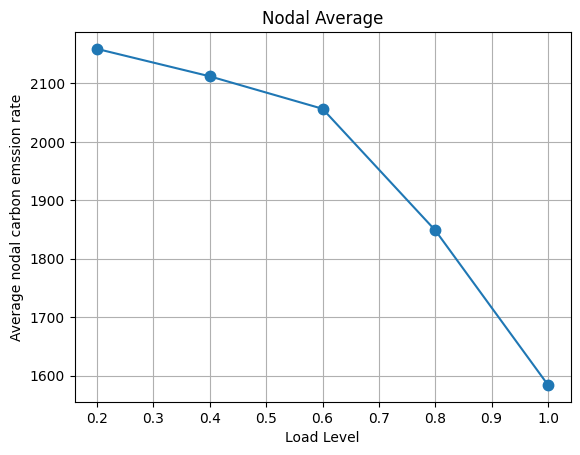

In [57]:
y = np.average(res, axis=1)
plt.title("Nodal Average")
plt.plot(percent, y, marker=".", markersize=15)
plt.grid()
plt.ylabel("Average nodal carbon emssion rate")
plt.xlabel("Load Level")